# 0.0. PREPARATION

## 0.1. Assumptions

Tenure -> time in months since customers joined the customer base

Balance -> amount of money spent by the customer

## 0.1. Imports

In [1]:
import pickle

import numpy             as np
import pandas            as pd
import seaborn           as sns

import sweetviz          as sv
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt

from boruta                import BorutaPy
from scipy                 import stats
from xgboost               import XGBClassifier
from IPython.core.display  import HTML
from sklearn.feature_selection import SelectFromModel

from imblearn import combine as cb
from sklearn import metrics         as mt
from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from sklearn import linear_model    as lm
from sklearn import preprocessing   as pp
from sklearn import model_selection as ms

## 0.2. Load Data

In [2]:
df_raw = pd.read_csv('../data/abandono_clientes.csv')

### 0.2.1. Split Test Data

In [3]:
df1, df_test = ms.train_test_split(df_raw, test_size=0.1)

## 0.3. Helper Functions

In [4]:
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

def corr_cramer_v(cat_attributes):
    cat_attributes_list = cat_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(cat_attributes[ref],cat_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

def cross_validation(models_performance, num_folds, modelName, model, x_train, y_train):
    kfold=ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)
    
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    i=1
    for train_cv,val_cv in kfold.split(x_train,y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict(x_val_fold)
        
        #x_val_fold['response'] = y_val_fold
        
        precision = mt.precision_score(y_val_fold, yhat_model)
        recall = mt.recall_score(y_val_fold, yhat_model)
        f1_score = mt.f1_score(y_val_fold, yhat_model, average='macro')
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)

        i+=1
    
    precision_str = np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)
    recall_str = np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)
    f1_score_str = np.round(np.mean(f1_score_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_score_list),4).astype(str)
    
    models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str], index=models_performance.columns), ignore_index=True)

    return models_performance

def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [5]:
jupyter_settings()

# 1.0. DATA DESCRIPTION

In [6]:
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7389,7390,15676909,Mishin,667,Spain,Female,34,5,0.00,2,1,0,163830.64,0
8154,8155,15791533,Ch'ien,367,Spain,Male,42,6,93608.28,1,1,0,168816.73,1
1545,1546,15673908,Chinweike,602,Germany,Female,42,6,158414.85,1,1,1,131886.46,0
3624,3625,15596710,Ku,640,France,Female,33,1,167298.42,1,0,1,145381.65,0
6072,6073,15803908,Fu,628,France,Male,45,9,0.00,2,1,1,96862.56,0


## 1.1. Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 9000
Number of columns: 14


## 1.2. Data Types

In [8]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 1.3. Checks

In [9]:
# check na
df1.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
# check duplicates
df1.duplicated().sum()

0

In [11]:
# check balance
df1['Exited'].value_counts(normalize=True)

0    0.798667
1    0.201333
Name: Exited, dtype: float64

## 1.4. Descriptive Analysis

In [12]:
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7389,7390,15676909,Mishin,667,Spain,Female,34,5,0.00,2,1,0,163830.64,0
8154,8155,15791533,Ch'ien,367,Spain,Male,42,6,93608.28,1,1,0,168816.73,1
1545,1546,15673908,Chinweike,602,Germany,Female,42,6,158414.85,1,1,1,131886.46,0
3624,3625,15596710,Ku,640,France,Female,33,1,167298.42,1,0,1,145381.65,0
6072,6073,15803908,Fu,628,France,Male,45,9,0.00,2,1,1,96862.56,0


In [13]:
num_attributes = df1[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']]
cat_attributes = df1[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']]

### 1.4.1. Numerical Attributes

In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat metrics
num_statics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num_statics.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [15]:
num_statics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,CreditScore,350.00,850.00,500.00,649.889778,651.00,96.929687,-0.067501,-0.424154
1,Age,18.00,92.00,74.00,38.920222,37.00,10.484670,1.024046,1.441086
2,Tenure,0.00,10.00,10.00,4.996889,5.00,2.888327,0.017050,-1.163859
3,Balance,0.00,250898.09,250898.09,76153.673377,96950.71,62416.124956,-0.132882,-1.495012
4,NumOfProducts,1.00,4.00,3.00,1.529111,1.00,0.580266,0.743191,0.588911
5,EstimatedSalary,11.58,199992.48,199980.90,100222.502737,100547.89,57370.358620,-0.003092,-1.174623


### 1.4.2. Categorical Attributes

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

Geography         3
Gender            2
HasCrCard         2
IsActiveMember    2
Exited            2
dtype: int64

### 1.4.3. Pandas Profiling

In [17]:
# prof = ProfileReport(df1)
# prof.to_file(output_file='../reports/output.html')

**Notes From Pandas Profiling Report**

* Maximum value of CreditScore (850) is the most common.
* Column Age could be similar to normal distribution.
* Tenure has low variance.
* Lot of zeroes in Balance (36%).
* Some very low values in EstimatedSalary.
* Imbalanced problem (80/20)

# 2.0. FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

In [19]:
df2.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7389,7390,15676909,Mishin,667,Spain,Female,34,5,0.00,2,1,0,163830.64,0
8154,8155,15791533,Ch'ien,367,Spain,Male,42,6,93608.28,1,1,0,168816.73,1
1545,1546,15673908,Chinweike,602,Germany,Female,42,6,158414.85,1,1,1,131886.46,0
3624,3625,15596710,Ku,640,France,Female,33,1,167298.42,1,0,1,145381.65,0
6072,6073,15803908,Fu,628,France,Male,45,9,0.00,2,1,1,96862.56,0


In [20]:
# average ticket
df2['AvgTicket'] = np.round(df2['Balance'] / df2['NumOfProducts'], 2)

df2['BalanceMonth'] = [np.round(x['Balance'] / x['Tenure'], 2) if x['Tenure'] != 0 else x['Balance'] for _, x in df2.iterrows()]


# 3.0. DATA FILTERING

In [21]:
df3 = df2.copy()

In [22]:
# drop meaningless columns
df3 = df3.drop(['RowNumber', 'Surname'], axis = 1)

# 4.0. EXPLORATORY DATA ANALYSIS

In [23]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [24]:
num_attributes = df4[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'AvgTicket', 'BalanceMonth']]
cat_attributes = df4[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']]

### 4.1.1. Response Variable

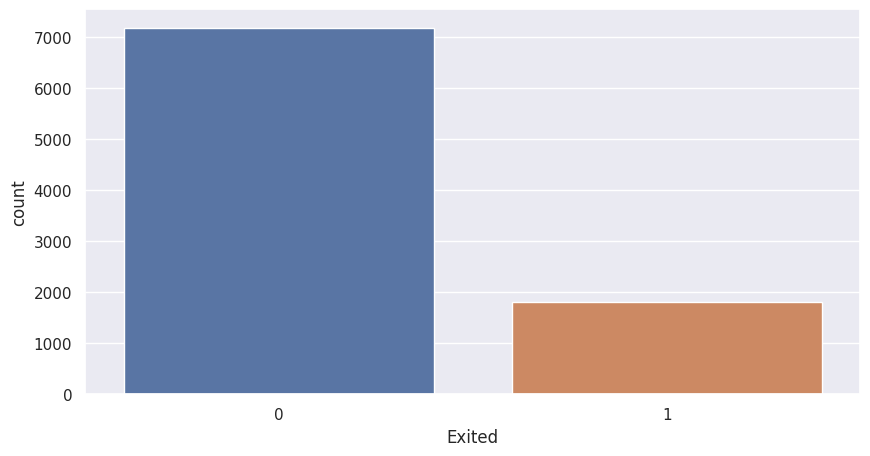

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='Exited', data=df4);

### 4.1.2. Numerical Variables

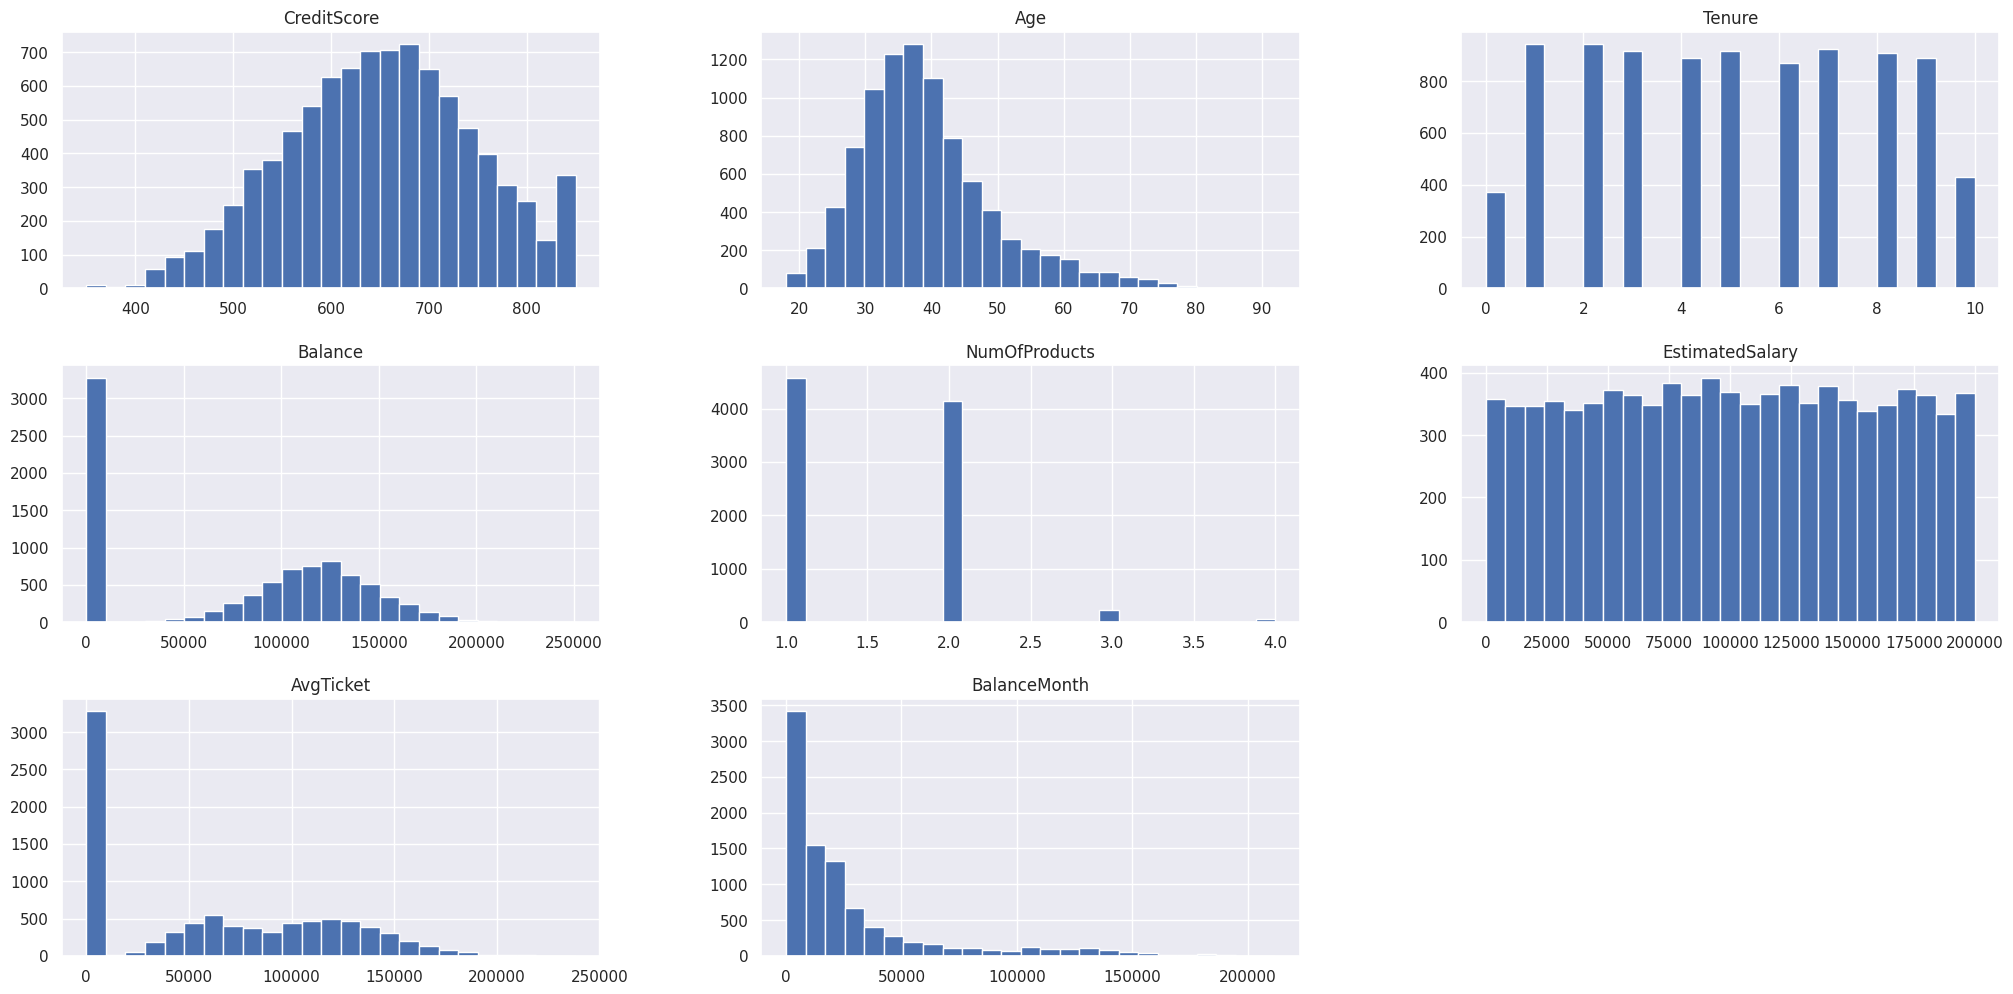

In [26]:
num_attributes.hist(bins=25);

/tmp/ipykernel_10131/2158198755.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


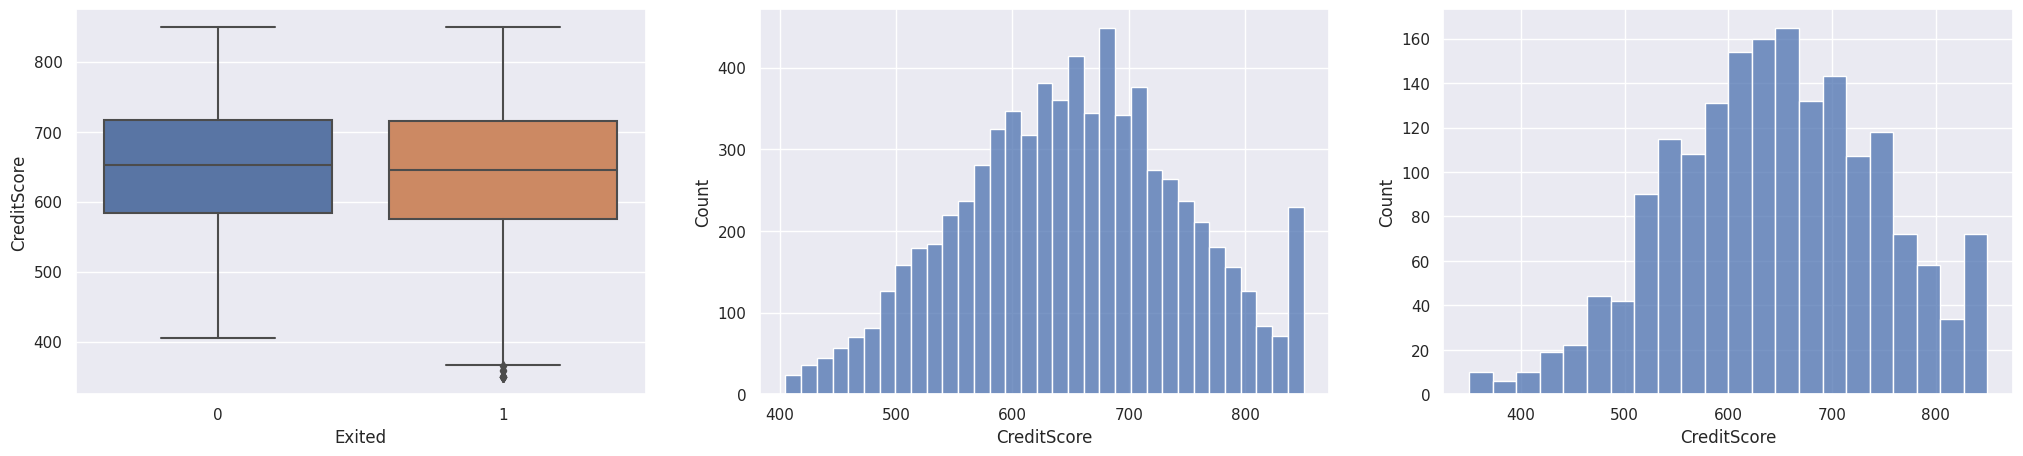

In [27]:
# Credit Score
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='CreditScore', data=df4);

plt.subplot(1,3,2)
CreditScore0 = df4.loc[df4['Exited'] == 0, 'CreditScore']
sns.histplot(CreditScore0);

plt.subplot(1,3,3)
CreditScore1 = df4.loc[df4['Exited'] == 1, 'CreditScore']
sns.histplot(CreditScore1);

/tmp/ipykernel_10131/1261668618.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


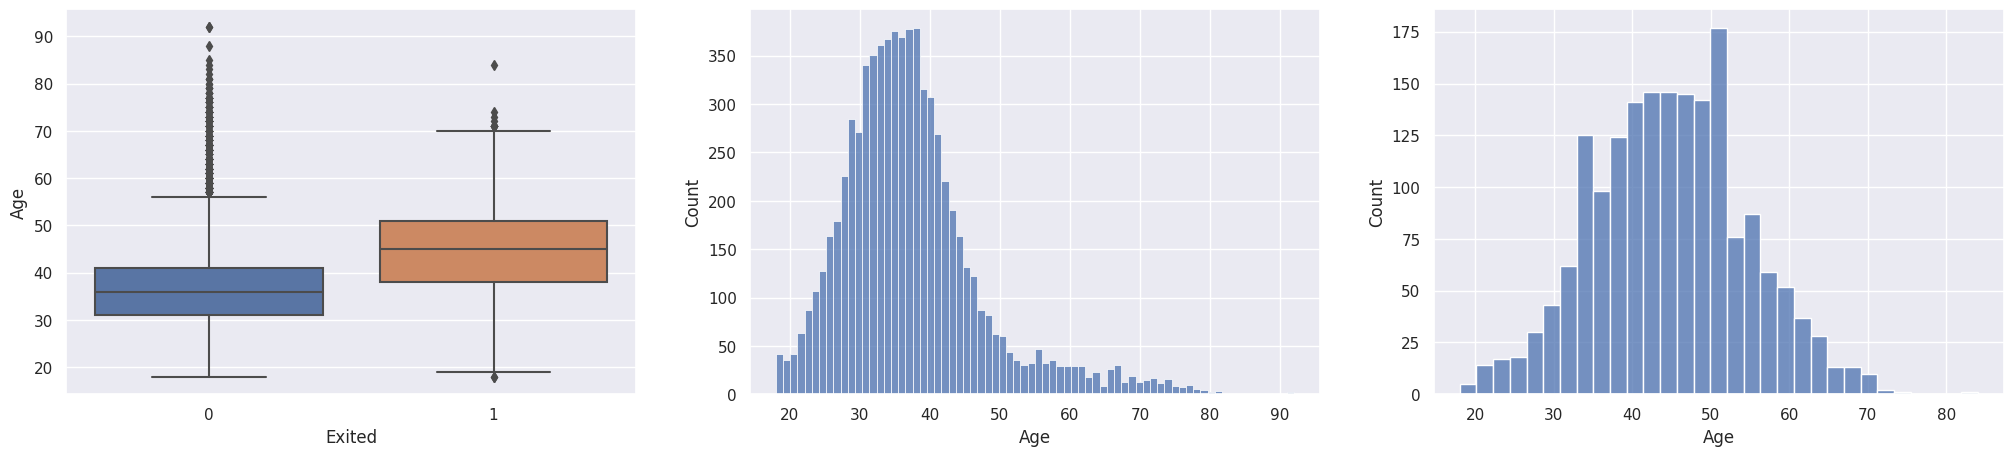

In [28]:
# Age
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='Age', data=df4);

plt.subplot(1,3,2)
Age0 = df4.loc[df4['Exited'] == 0, 'Age']
sns.histplot(Age0);

plt.subplot(1,3,3)
Age1 = df4.loc[df4['Exited'] == 1, 'Age']
sns.histplot(Age1);

/tmp/ipykernel_10131/2524579783.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


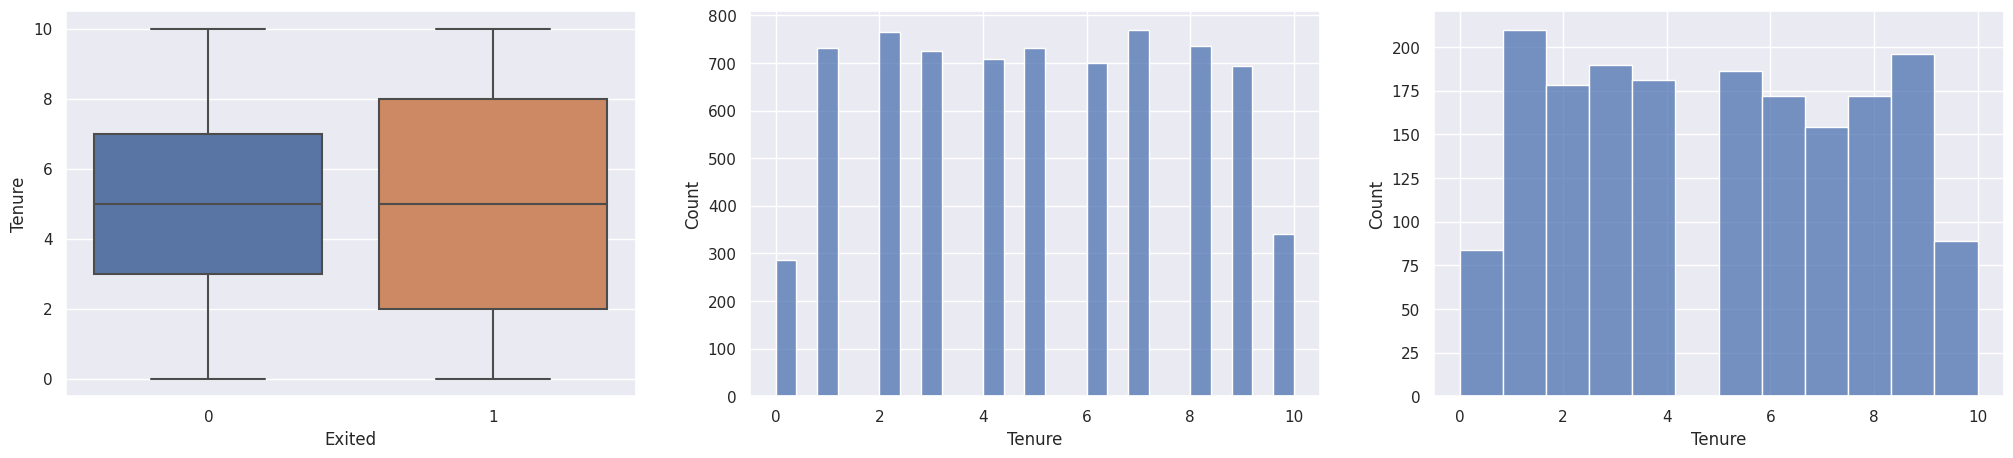

In [29]:
# Tenure
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='Tenure', data=df4);

plt.subplot(1,3,2)
Tenure0 = df4.loc[df4['Exited'] == 0, 'Tenure']
sns.histplot(Tenure0);

plt.subplot(1,3,3)
Tenure1 = df4.loc[df4['Exited'] == 1, 'Tenure']
sns.histplot(Tenure1);

/tmp/ipykernel_10131/3530946033.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


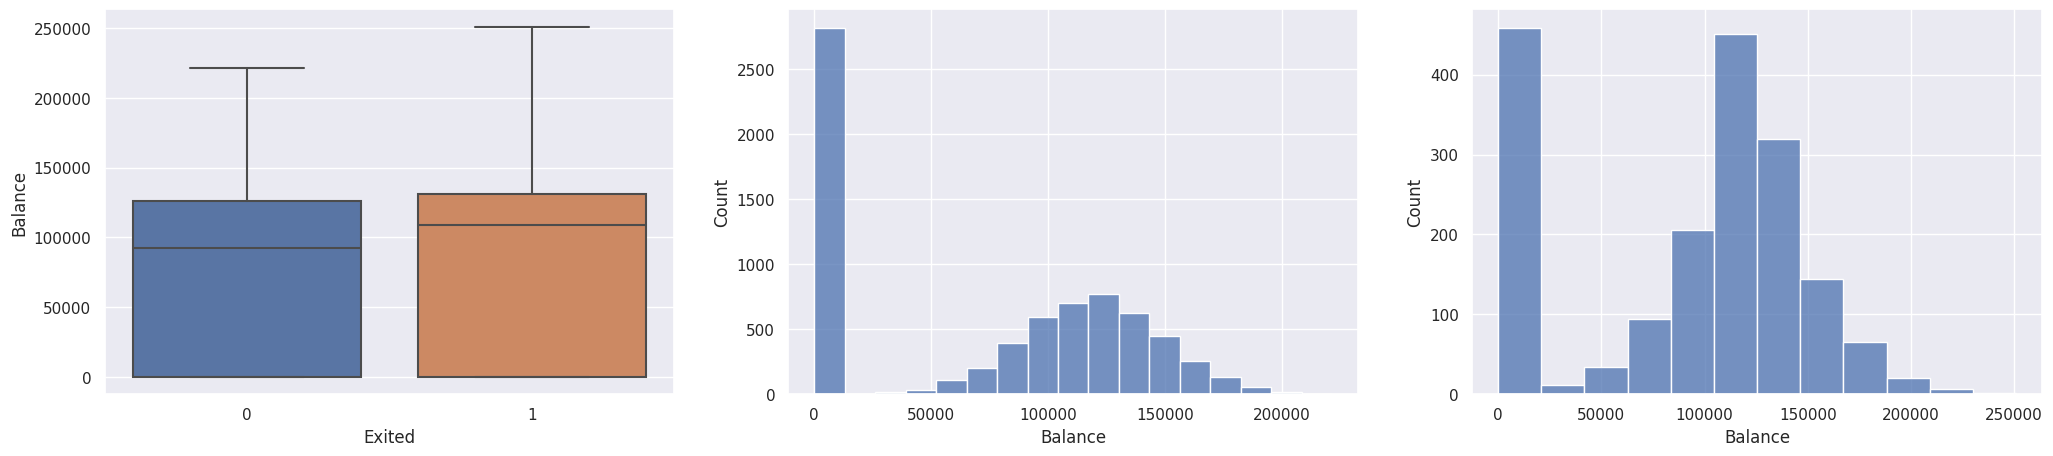

In [30]:
# Balance
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='Balance', data=df4);

plt.subplot(1,3,2)
Balance0 = df4.loc[df4['Exited'] == 0, 'Balance']
sns.histplot(Balance0);

plt.subplot(1,3,3)
Balance1 = df4.loc[df4['Exited'] == 1, 'Balance']
sns.histplot(Balance1);

/tmp/ipykernel_10131/1650660008.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


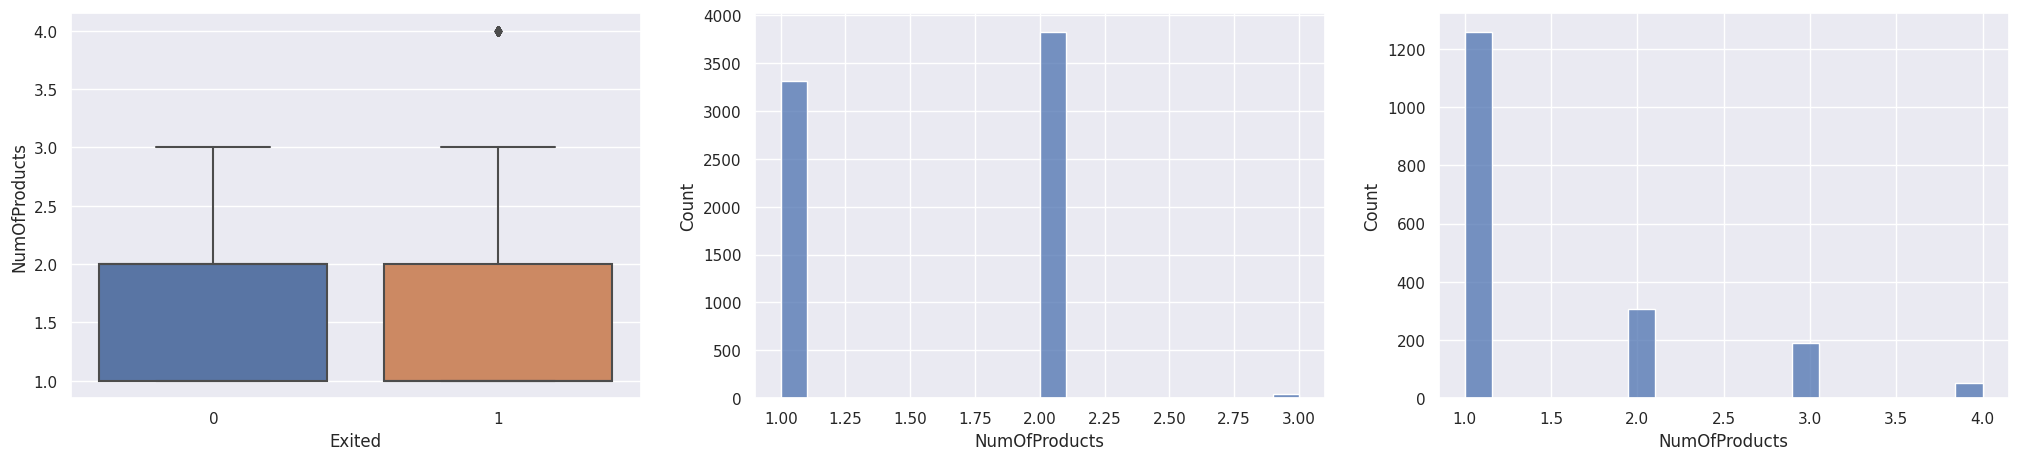

In [31]:
# NumOfProducts
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='NumOfProducts', data=df4);

plt.subplot(1,3,2)
NumOfProducts0 = df4.loc[df4['Exited'] == 0, 'NumOfProducts']
sns.histplot(NumOfProducts0);

plt.subplot(1,3,3)
NumOfProducts1 = df4.loc[df4['Exited'] == 1, 'NumOfProducts']
sns.histplot(NumOfProducts1);

/tmp/ipykernel_10131/238950735.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


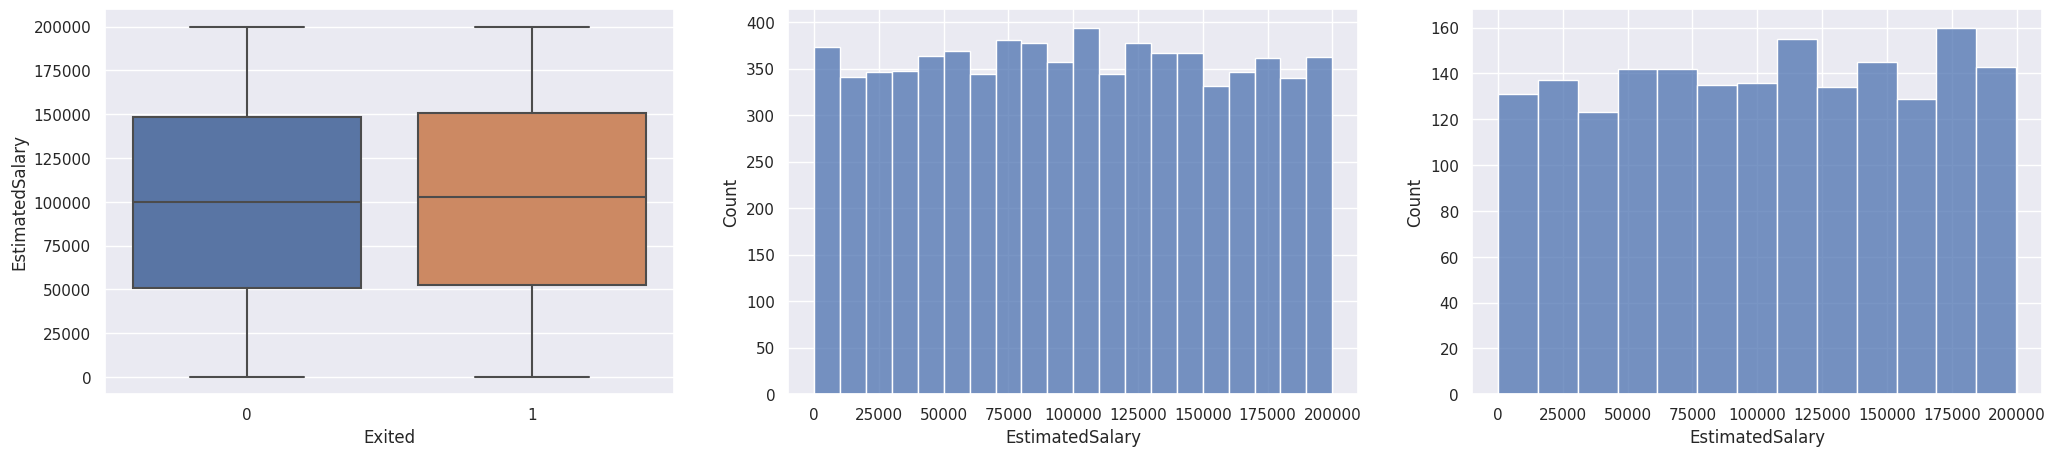

In [32]:
# EstimatedSalary
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='EstimatedSalary', data=df4);

plt.subplot(1,3,2)
EstimatedSalary0 = df4.loc[df4['Exited'] == 0, 'EstimatedSalary']
sns.histplot(EstimatedSalary0);

plt.subplot(1,3,3)
EstimatedSalary1 = df4.loc[df4['Exited'] == 1, 'EstimatedSalary']
sns.histplot(EstimatedSalary1);

/tmp/ipykernel_10131/3995312931.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


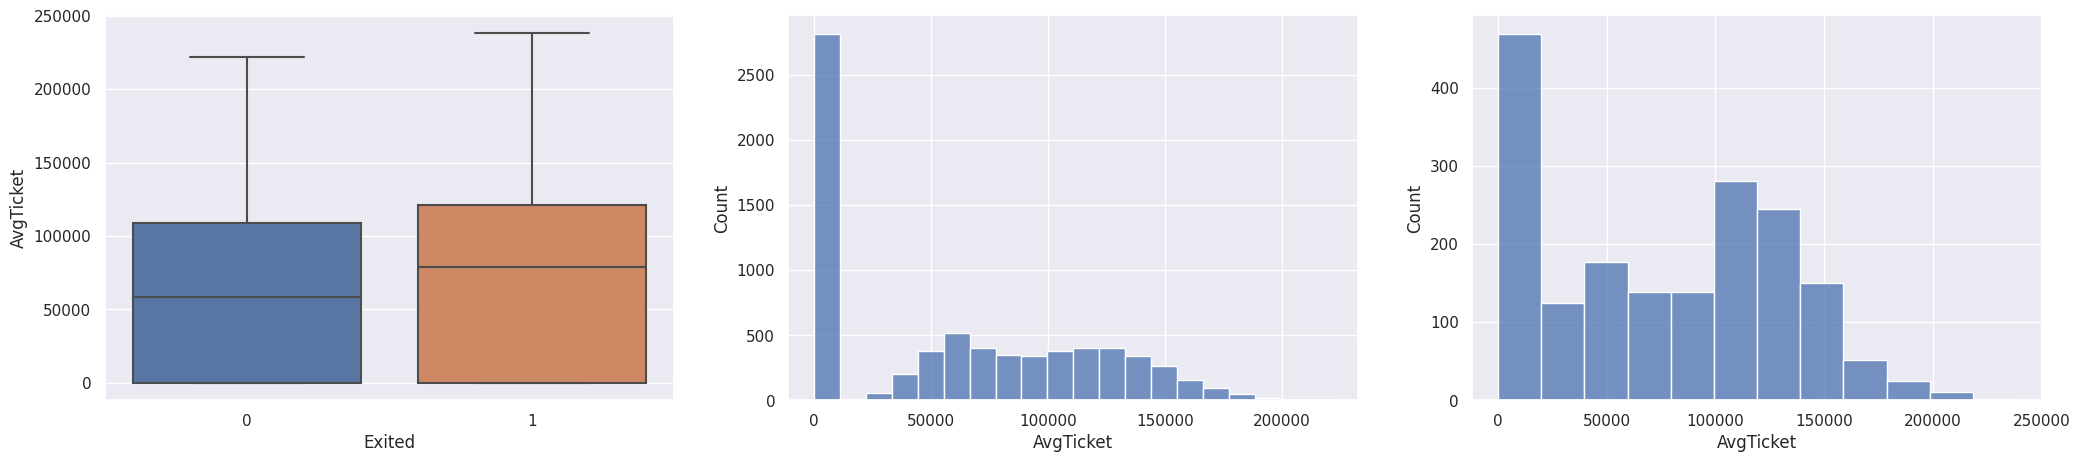

In [33]:
# AvgTicket
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='AvgTicket', data=df4);

plt.subplot(1,3,2)
AvgTicket0 = df4.loc[df4['Exited'] == 0, 'AvgTicket']
sns.histplot(AvgTicket0);

plt.subplot(1,3,3)
AvgTicket1 = df4.loc[df4['Exited'] == 1, 'AvgTicket']
sns.histplot(AvgTicket1);

/tmp/ipykernel_10131/2699302242.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


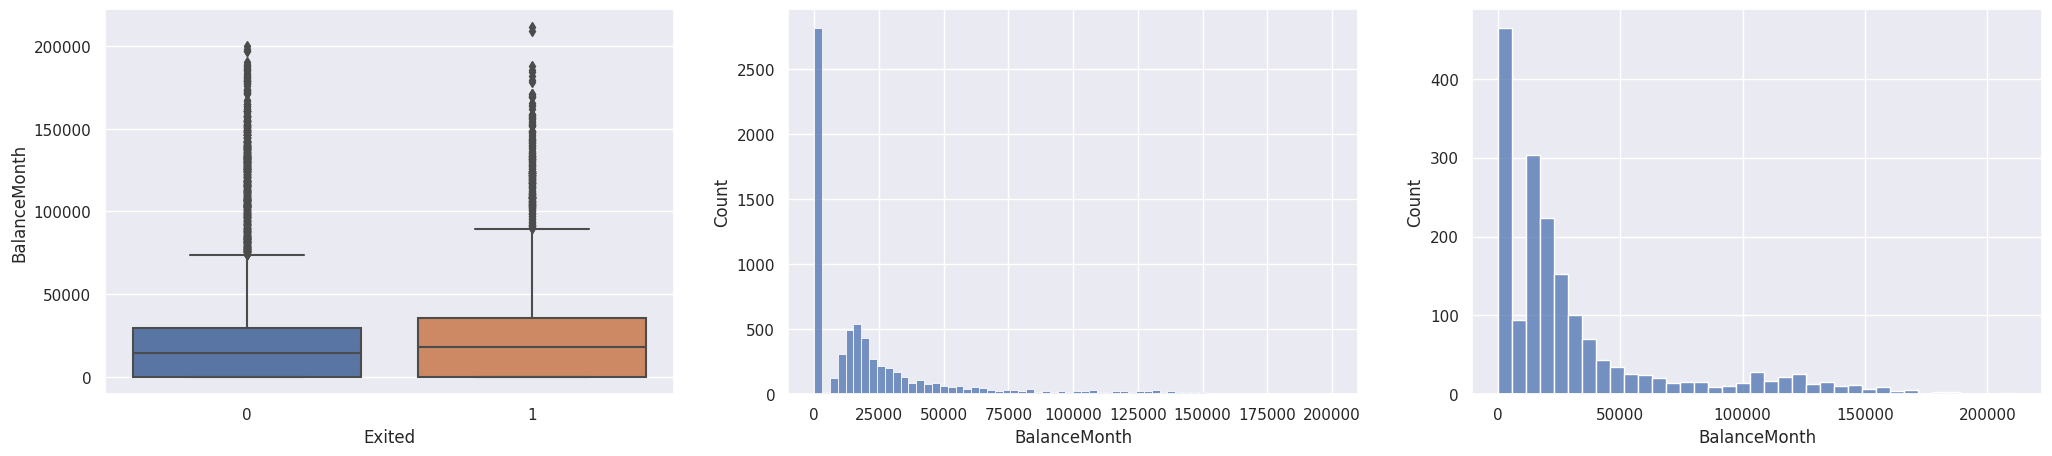

In [34]:
# BalanceMonth
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='BalanceMonth', data=df4);

plt.subplot(1,3,2)
BalanceMonth0 = df4.loc[df4['Exited'] == 0, 'BalanceMonth']
sns.histplot(BalanceMonth0);

plt.subplot(1,3,3)
BalanceMonth1 = df4.loc[df4['Exited'] == 1, 'BalanceMonth']
sns.histplot(BalanceMonth1);

### 4.1.3. Categorical Variables

In [35]:
df_churn = df4[df4['Exited'] == 1]
df_nchurn = df4[df4['Exited'] == 0]

/tmp/ipykernel_10131/710844022.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


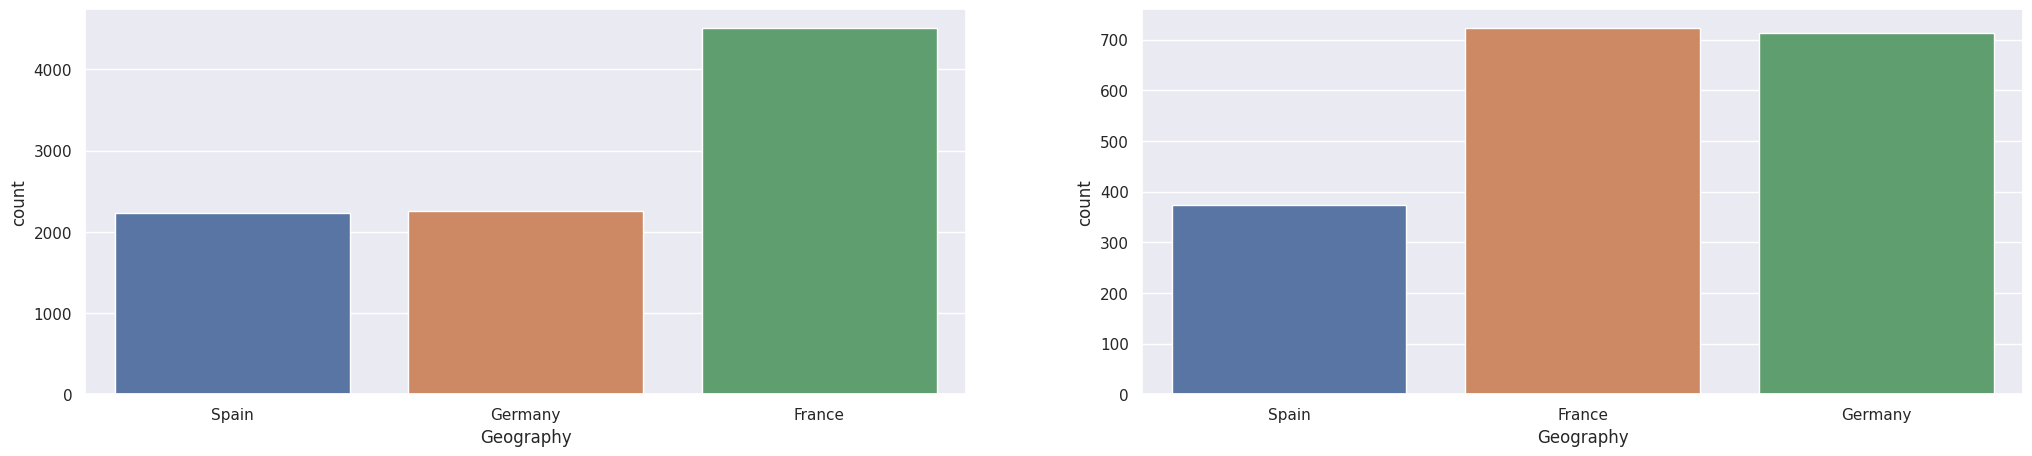

In [36]:
# geography
plt.subplots(figsize=(25, 5))
plt.subplot(1,2,1)
sns.countplot(x='Geography', data=df4);

plt.subplot(1,2,2)
sns.countplot(x='Geography', data=df_churn);

/tmp/ipykernel_10131/3242352414.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


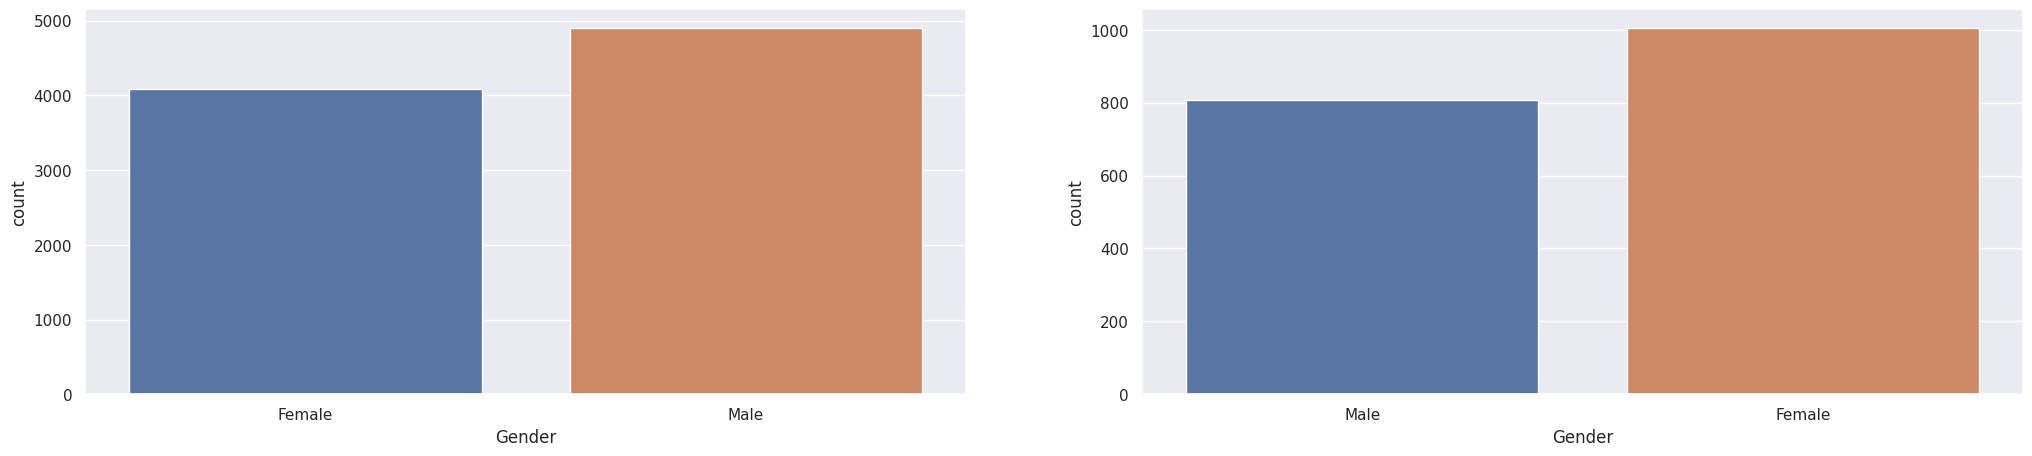

In [37]:
# gender
plt.subplots(figsize=(25, 5))
plt.subplot(1,2,1)
sns.countplot(x='Gender', data=df4);

plt.subplot(1,2,2)
sns.countplot(x='Gender', data=df_churn);

/tmp/ipykernel_10131/1413657579.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


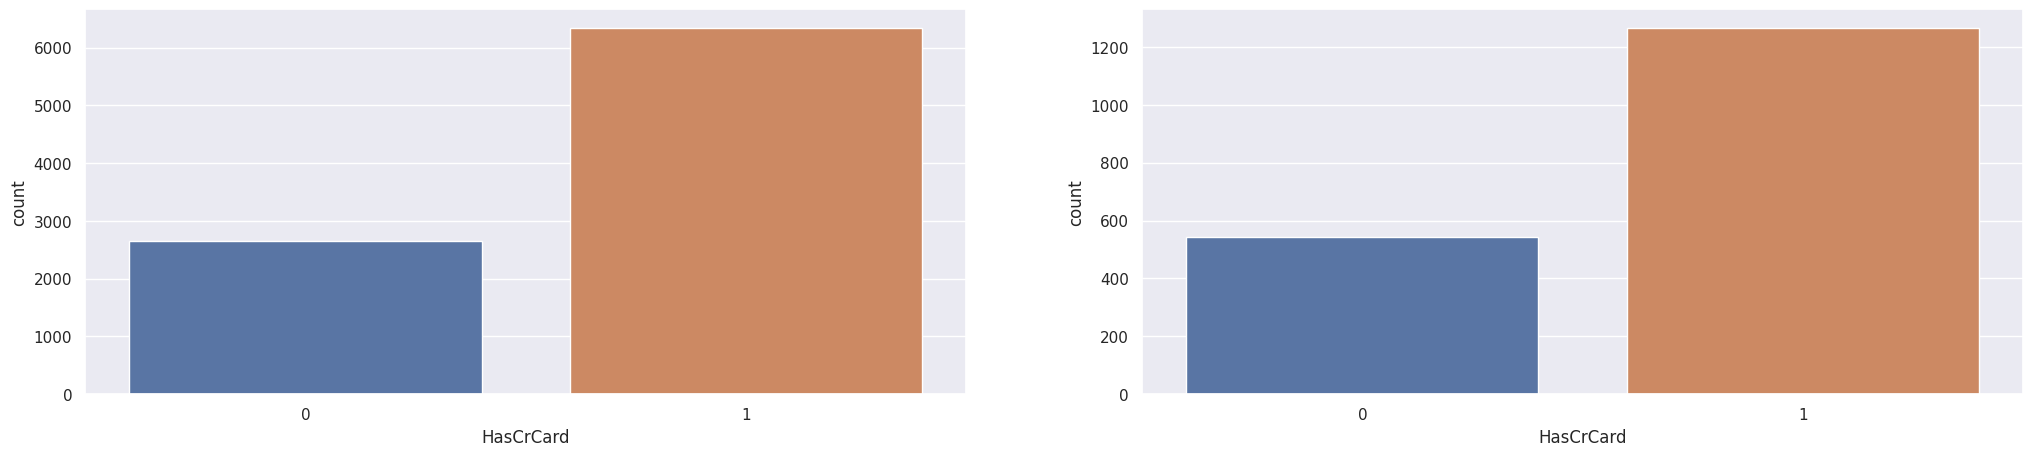

In [38]:
# has credit card
plt.subplots(figsize=(25, 5))
plt.subplot(1,2,1)
sns.countplot(x='HasCrCard', data=df4);

plt.subplot(1,2,2)
sns.countplot(x='HasCrCard', data=df_churn);

/tmp/ipykernel_10131/3152507493.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


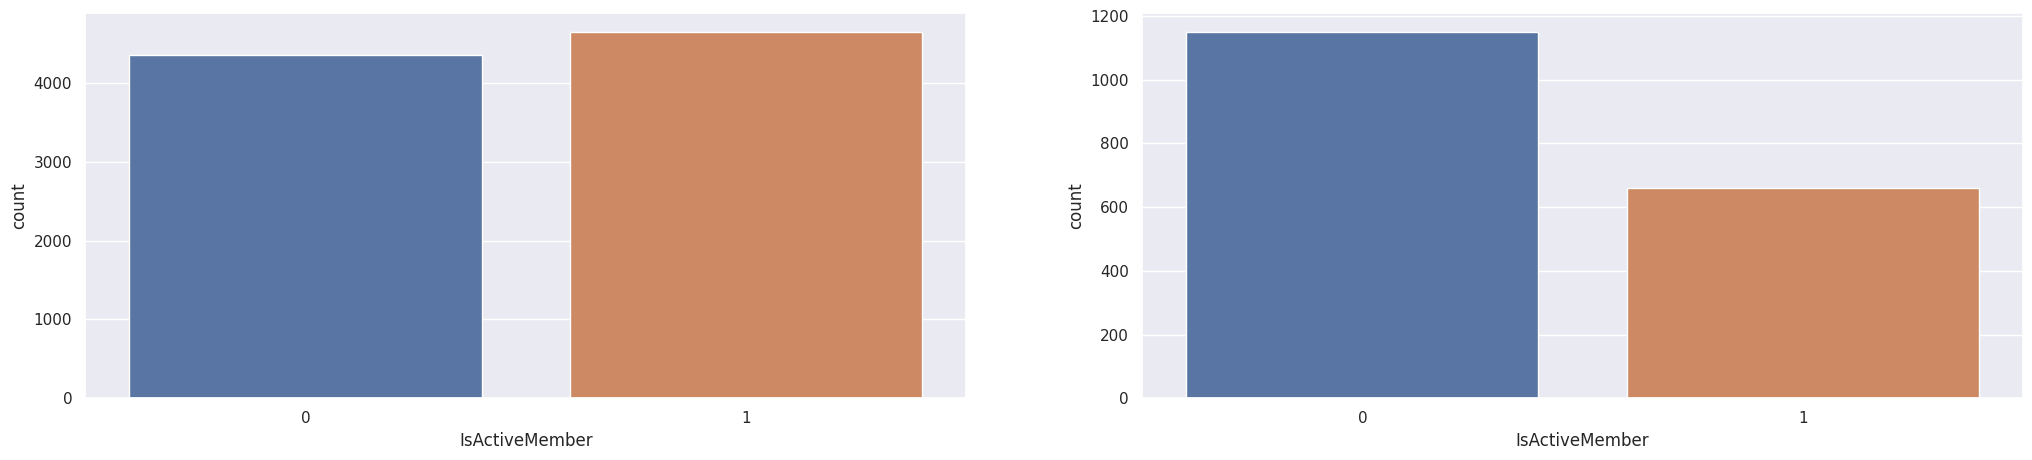

In [39]:
# is active
plt.subplots(figsize=(25, 5))
plt.subplot(1,2,1)
sns.countplot(x='IsActiveMember', data=df4);

plt.subplot(1,2,2)
sns.countplot(x='IsActiveMember', data=df_churn);

## 4.2. Bivariate Analysis

In [40]:
# create business hypotesis and validate with bivariate analysis

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Variables

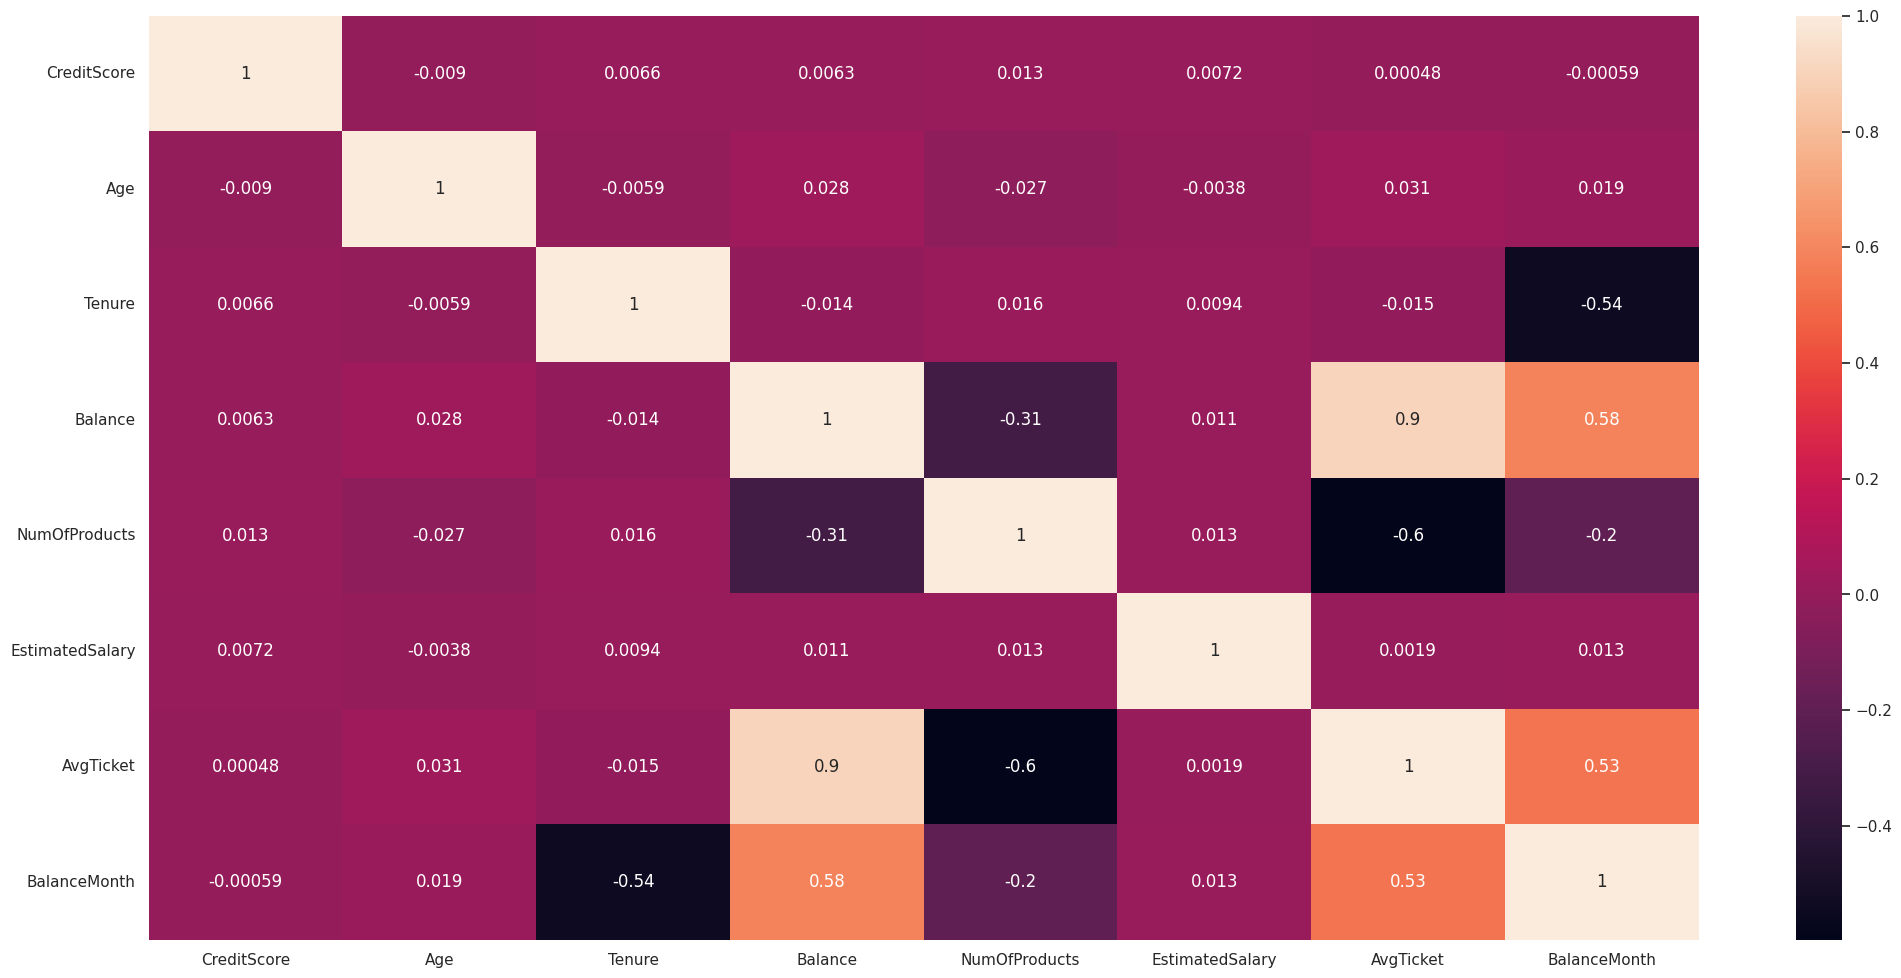

In [41]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Variables

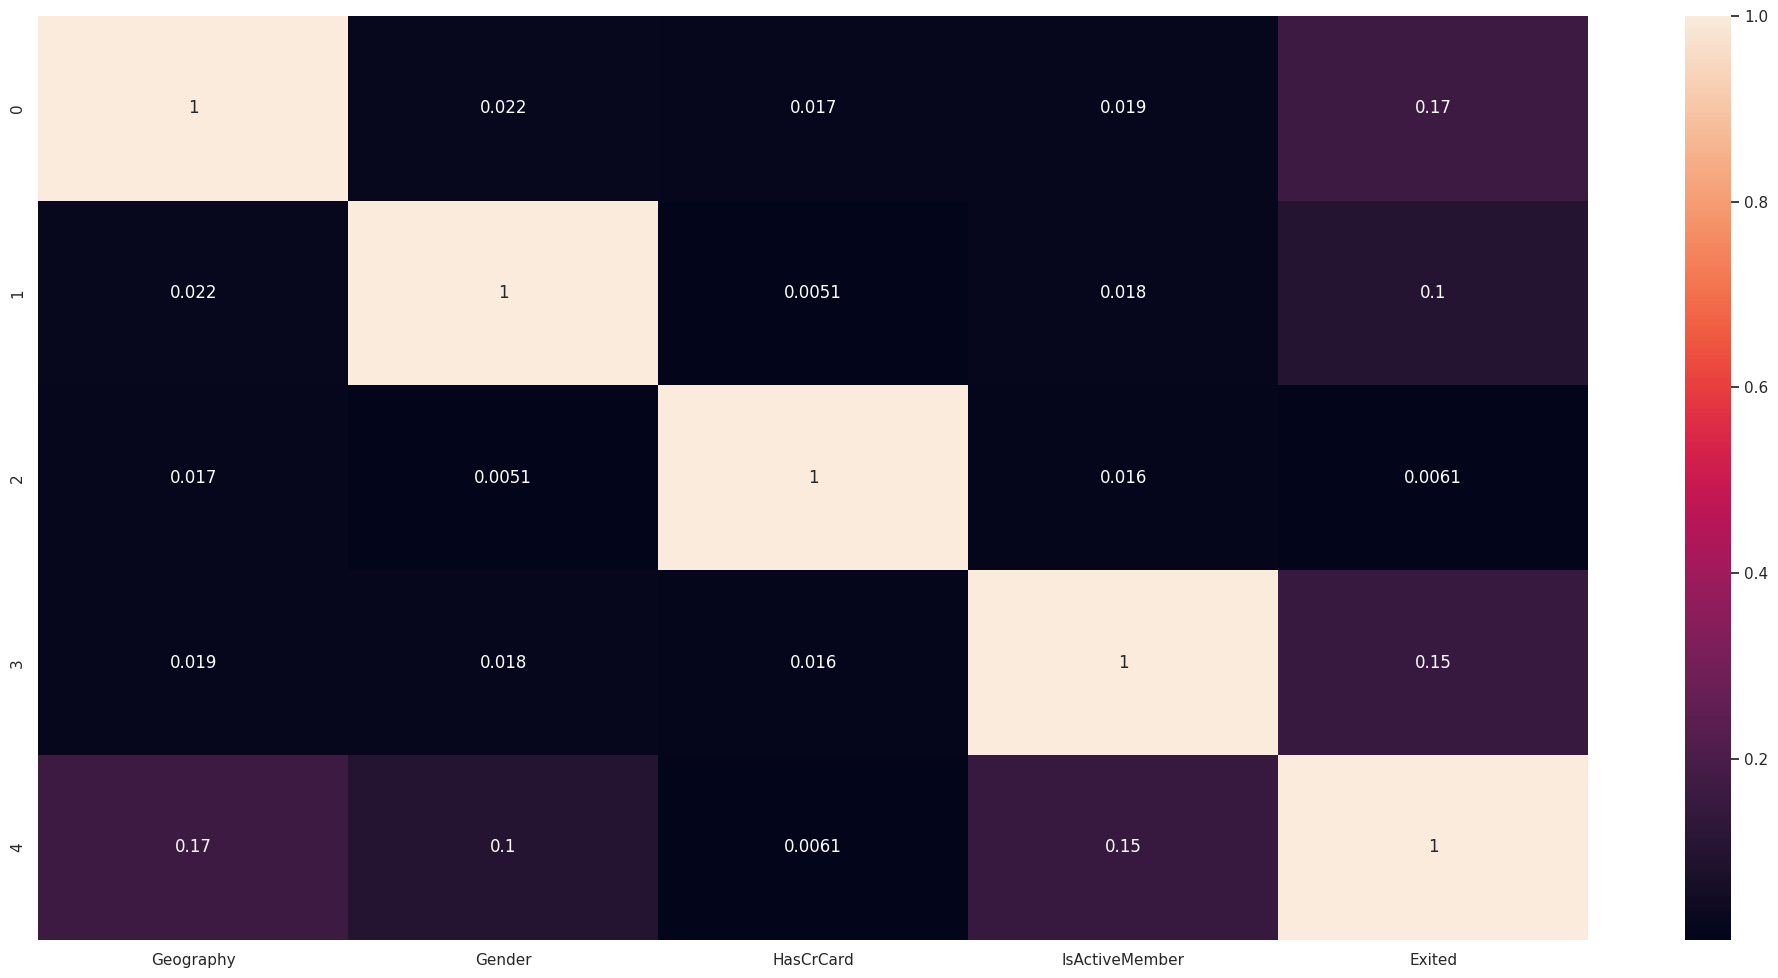

In [42]:
sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot=True);

# 5.0. DATA PREPARATION

In [43]:
df5 = df4.copy()

# drop customer id
df5.drop('CustomerId', axis=1, inplace=True)

## 5.1. Standardization

In [44]:
# looking at session 4.1.2, the only feature that resemble a normal distribution is CredictScore
ss = pp.StandardScaler()

df5['CreditScore'] = ss.fit_transform(df5[['CreditScore']].values)
pickle.dump(ss, open('/home/felipe/repos/churn_indi/src/parameters/CreditScoreScaler.pkl', 'wb'))

## 5.2. Rescaling

In [45]:
mm = pp.MinMaxScaler()
rs = pp.RobustScaler()

In [46]:
# Age
df5['Age'] = rs.fit_transform(df5[['Age']].values)
pickle.dump(rs, open('/home/felipe/repos/churn_indi/src/parameters/AgeScaler.pkl', 'wb'))

# Tenure
df5['Tenure'] = mm.fit_transform(df5[['Tenure']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/TenureScaler.pkl', 'wb'))

# Balance
df5['Balance'] = mm.fit_transform(df5[['Balance']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/BalanceScaler.pkl', 'wb'))

# Number of Products
df5['NumOfProducts'] = mm.fit_transform(df5[['NumOfProducts']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/NumOfProductsScaler.pkl', 'wb'))

# Estimated Salary
df5['EstimatedSalary'] = mm.fit_transform(df5[['EstimatedSalary']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/EstimatedSalaryScaler.pkl', 'wb'))

# Average Ticket
df5['AvgTicket'] = mm.fit_transform(df5[['AvgTicket']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/AvgTicketScaler.pkl', 'wb'))

## 5.3. Encoding

In [47]:
# geography - One Hot Encoding
df5 = pd.get_dummies(df5, prefix='Geography', columns=['Geography'], dtype='int64')

# gender- One Hot Encoding
df5 = pd.get_dummies(df5, columns=['Gender'], dtype='int64')

## 5.4. BALANCED DATA

In [49]:
# SMOTE + Tomekling
# define sampler
smt = cb.SMOTETomek(sampling_strategy='auto', random_state=32, n_jobs=-1)

# apply sampler
X_smt, y_smt = smt.fit_resample(df5, df5['Exited'])

/home/felipe/repos/churn_indi/churn_ind_env/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


## 5.4. Train and Validation Split

In [59]:
# split training and validation datasets
X = X_smt.drop('Exited', axis=1)
y = X_smt['Exited'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)

# 6.0. FEATURE SELECTION

In [60]:
df6 = df5.copy()

### 6.1. Extra Tree Classifier

In [50]:
# # model definition
# forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# # data preparation
# x_train_n = df6.drop('Exited', axis=1)
# y_train_n = df6['Exited']
# forest.fit(x_train_n, y_train_n)

In [51]:
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]

# # print the feature ranking
# print('Feature Ranking:')
# df = pd.DataFrame()
# for i, j in zip(x_train_n, forest.feature_importances_):
#     aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
#     df = pd.concat([df, aux], axis=0)
    
# print(df.sort_values('importance', ascending=False))

# # plot the impurity-based feature importance of the forest
# plt.figure()
# plt.title('Feature Importances')
# plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
# plt.xticks(range(x_train_n.shape[1]), indices)
# plt.xlim([-1, x_train_n.shape[1]])
# plt.show()

# 7.0. MACHINE LEARNING MODELING

In [61]:
# # best features found by extra trees
# cols_selected_tree = ['Age', 'NumOfProducts', 'CreditScore', 'EstimatedSalary', 'AvgTicket', 'Balance', 'Tenure', 'BalanceMonth']

# cols_selected = ['CreditScore', 'Age', 'Tenure', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'AvgTicket', 'Geography_France', 'Geography_Germany', 
#                  'Geography_Spain', 'Gender_Female', 'Gender_Male']

x_train = x_train.drop('BalanceMonth', axis=1)
x_validation = x_validation.drop('BalanceMonth', axis=1)

## 7.1. Logistic Regression - Baseline

In [62]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict(x_validation)

In [63]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_lr)
recall = mt.recall_score(y_validation, yhat_lr)
f1_score = mt.f1_score(y_validation, yhat_lr, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.84269
Recall: 0.73811
F1 Score: 0.79910


## 7.2. KNN

In [64]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction 
yhat_knn = knn_model.predict(x_validation)

In [65]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_knn)
recall = mt.recall_score(y_validation, yhat_knn)
f1_score = mt.f1_score(y_validation, yhat_knn, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.84992
Recall: 0.83965
F1 Score: 0.84544


## 7.3. Gradient Boosting

In [66]:
## model definition
gdr_model = en.GradientBoostingClassifier(n_estimators=100, random_state=42)

# model training
gdr_model.fit(x_train, y_train)

# model prediction
yhat_gdr = gdr_model.predict(x_validation)

In [67]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_gdr)
recall = mt.recall_score(y_validation, yhat_gdr)
f1_score = mt.f1_score(y_validation, yhat_gdr, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.90659
Recall: 0.87591
F1 Score: 0.89263


## 7.4. Random Forest

In [68]:
# model definition
rf_model = en.RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=None)

# model training
rf_model.fit(x_train, y_train)

# model prediction
yhat_rf = rf_model.predict(x_validation)

In [69]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_rf)
recall = mt.recall_score(y_validation, yhat_rf)
f1_score = mt.f1_score(y_validation, yhat_rf, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.92288
Recall: 0.88719
F1 Score: 0.90635


## 7.5. XGBoost

In [70]:
# model definition
xgb_model = XGBClassifier()

# model training
xgb_model.fit(x_train,y_train.values.ravel())

# model prediction
yhat_xgb = xgb_model.predict(x_validation)

In [71]:
# calculate metrics
precision = mt.precision_score(y_validation, yhat_xgb)
recall = mt.recall_score(y_validation, yhat_xgb)
f1_score = mt.f1_score(y_validation, yhat_xgb, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.92445
Recall: 0.87752
F1 Score: 0.90269


# 9.0. CROSS VALIDATION

In [72]:
# prepare cross validation data
x_train_cv = df6.drop(['Exited', 'BalanceMonth'], axis = 1)
y_train_cv = df6['Exited']


In [73]:
models_performance_cv = pd.DataFrame({'Model':[], "Precision": [], "Recall": [], "F1_Score": []})
models_performance_cv = cross_validation(models_performance_cv, 5 , 'logistic_regression', lr_model , x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'knn'                , knn_model, x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'gradient_boosting'  , gdr_model, x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'random_forest'      , rf_model , x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'xgboost_cv'         , xgb_model, x_train_cv, y_train_cv)

/tmp/ipykernel_10131/2575200869.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str], index=models_performance.columns), ignore_index=True)
/tmp/ipykernel_10131/2575200869.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str], index=models_performance.columns), ignore_index=True)
/tmp/ipykernel_10131/2575200869.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str], index=models_performance.columns), ig

In [74]:
models_performance_cv

,Model,Precision,Recall,F1_Score
0,logistic_regression,0.5925 +/- 0.0118,0.1959 +/- 0.0257,0.5924 +/- 0.0156
1,knn,0.6286 +/- 0.0404,0.2693 +/- 0.0191,0.6358 +/- 0.012
2,gradient_boosting,0.7727 +/- 0.025,0.4641 +/- 0.0278,0.7492 +/- 0.0121
3,random_forest,0.7671 +/- 0.0339,0.4581 +/- 0.0216,0.7453 +/- 0.0061
4,xgboost_cv,0.7011 +/- 0.0405,0.4939 +/- 0.0253,0.7455 +/- 0.0112


# 9.0. MODEL PERFORMANCE

## 9.1. Retrain Model With All Data

In [75]:
# concat training and validation datasets
x_retrain = pd.concat([x_train, x_validation])
y_retrain = pd.concat([y_train, y_validation])

In [76]:
## model definition
model = en.GradientBoostingClassifier(n_estimators=100, random_state=42)

# model training
model.fit(x_retrain, y_retrain)

# # model prediction
# yhat_gdr = gdr_model.predict(x_validation)

GradientBoostingClassifier(random_state=42)

## 9.2. Test Dataset Preparation

In [77]:
df_test = df_test.copy()

In [78]:
# split response variable
x_test = df_test.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis = 1)
y_test = df_test['Exited']

In [79]:
x_test['AvgTicket'] = [np.round(x['Balance'] / x['NumOfProducts'], 2) if x['NumOfProducts'] != 0 else 0 for _, x in x_test.iterrows()]

In [80]:
# loade pickle scalers
CreditScoreScaler     = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/CreditScoreScaler.pkl', 'rb'))
AgeScaler             = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/AgeScaler.pkl', 'rb'))
TenureScaler          = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/TenureScaler.pkl', 'rb'))
BalanceScaler         = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/BalanceScaler.pkl', 'rb'))
NumOfProductsScaler   = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/NumOfProductsScaler.pkl', 'rb'))
EstimatedSalaryScaler = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/EstimatedSalaryScaler.pkl', 'rb'))
AvgTicketScaler       = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/AvgTicketScaler.pkl', 'rb'))

In [81]:
# standardization

# CreditScore
x_test['CreditScore'] = CreditScoreScaler.transform(x_test[['CreditScore']].values)

# Age
x_test['Age'] = AgeScaler.transform(x_test[['Age']].values)

# Tenure
x_test['Tenure'] = TenureScaler.transform(x_test[['Tenure']].values)

# Balance
x_test['Balance'] = BalanceScaler.transform(x_test[['Balance']].values)

# NumOfProducts
x_test['NumOfProducts'] = NumOfProductsScaler.transform(x_test[['NumOfProducts']].values)

# EstimatedSalary
x_test['EstimatedSalary'] = EstimatedSalaryScaler.transform(x_test[['EstimatedSalary']].values)

# AvgTicket
x_test['AvgTicket'] = AvgTicketScaler.transform(x_test[['AvgTicket']].values)

# geography - One Hot Encoding
x_test = pd.get_dummies(x_test, prefix='Geography', columns=['Geography'], dtype='int64')

# gender- One Hot Encoding
x_test = pd.get_dummies(x_test, columns=['Gender'], dtype='int64')

In [82]:
x_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,AvgTicket,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
9883,0.290006,0.333333,0.2,0.590232,0.000000,1,0,0.070364,0.621207,1,0,0,0,1
411,2.064488,0.083333,0.1,0.000000,0.333333,1,1,0.400014,0.000000,1,0,0,0,1
8239,-0.112347,-0.250000,0.7,0.597613,0.333333,0,0,0.783261,0.314488,0,0,1,0,1
602,0.382857,2.916667,0.9,0.000000,0.000000,0,1,0.349122,0.000000,1,0,0,1,0
1640,-0.690086,0.833333,0.5,0.408780,0.000000,1,0,0.463527,0.430233,0,0,1,0,1


In [83]:
# apply retrained model
pred_test = model.predict(x_test)

In [84]:
# performance
# calculate metrics
precision = mt.precision_score(y_test, pred_test)
recall = mt.recall_score(y_test, pred_test)
f1_score = mt.f1_score(y_test, pred_test, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.70647
Recall: 0.63111
F1 Score: 0.78823


# 8.0. HYPERPARAMETER FINE TUNING